In [1]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np 
import matplotlib.pyplot as plt 
import copy 
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    window_size, window_step = map(int, (window_size, window_step))
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    step = int(step)
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec

In [3]:
def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)
    
def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"
    
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000, samplerate=44100):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(nfilt=n_freq_components, 
                                           nfft=fft_size, samplerate=samplerate, 
                                           lowfreq=start_freq, highfreq=end_freq)
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

In [4]:
### Parameters ###
fft_size = 1024 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 7000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 

In [5]:
# Generate the mel filters
mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq, samplerate = 16000)

In [ ]:
# path1 = 'cmu_arctic/canadian-english-male-jmk/wav/arctic_a0001.wav'
# path2 = 'cmu_arctic/indian-english-male-ksp/wav/arctic_a0001.wav'

# _, org_data_1 = wavfile.read(path1)
# _, org_data_2 = wavfile.read(path2)

# print(org_data_1.shape, org_data_2.shape)


In [ ]:
# IPython.display.Audio(data=org_data_1[:41316], rate=16000)

In [ ]:
# dist, dtw_path = fastdtw(org_data_1, org_data_2, dist = euclidean)
# print(dist)

# new_org_data_2 = [0] * len(org_data_1)
# prev_x = -1
# y_list = []
# for x, y in dtw_path:
#     if x == prev_x:
#         y_list.append(y)
#         continue
#     elif len(y_list)>1:
#         new_org_data_2[prev_x] = org_data_2[int(np.median(y_list))] #Selecting median from available indices
# #         new_org_data_2[prev_x] = np.mean(org_data_2[y_list[0]:y_list[-1]+1]) #Taking mean of all available options
    
#     new_org_data_2[x] = org_data_2[y]
#     prev_x = x
#     y_list = [y]
# print(len(new_org_data_2))
# #new_org_data_2 would be new indian accent wav aligned with that of canadian accent according to euclidean dist 


# SAVING MELSPECTROGRAMS OF CANADIAN ACCENT AS .npy FILES:

Considering only those whose melS is atleast 60 in x axis as those of Indian accent are shorter.

Taking only first 51 in the x axis (50 wasn't working while inverting for some reason)

In [28]:
path = 'cmu_arctic/canadian-english-male-jmk/'

In [30]:
namelist = [] #For selecting files from other accent
for filename in os.listdir(path + 'wav'):
    
    rate, org_data = wavfile.read(path + 'wav/' + filename)
    IPython.display.Audio(data=org_data, rate=rate)
    
    data = butter_bandpass_filter(org_data, lowcut, highcut, rate, order=1)
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    
    wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
    
    mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
    
    if(mel_spec.shape[1] >= 60):
        np.save(path + 'melS/' + filename[:-4] +'.npy', mel_spec[:, :51])
        namelist.append(filename)

/home/prathamesh/anaconda3/envs/new-tf/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [31]:
path2 = 'cmu_arctic/indian-english-male-ksp/'

In [32]:
len(namelist)

749

In [37]:
for filename in namelist:
    
    rate, org_data = wavfile.read(path2 + 'wav/' + filename)
    
    data = butter_bandpass_filter(org_data, lowcut, highcut, rate, order=1)
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    
    wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
    
    mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
    
    if(mel_spec.shape[1] > 50):
        np.save(path2 + 'melS/' + filename[:-4] +'.npy', mel_spec[:, :51])
    else:
        print(filename + 'skipped')
        
#This thing keeps running even after all files are saved for some reason!?

arctic_a0028.wavskipped


KeyboardInterrupt: 

arctic_a0028.wav from indian accent is skipped as it is too short

# Selecting one file from saved .npy files and inverting the melS to regenerate audio

In [39]:
mel_spec1 = np.load(path2 + 'melS/' + filename[:-4] +'.npy')
mel_spec1.shape

(64, 51)

In [55]:
mel_inverted_spectrogram = mel_to_spectrogram(mel_spec1[:, :51], mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

Text(0.5, 1.05, 'Inverted mel Spectrogram')

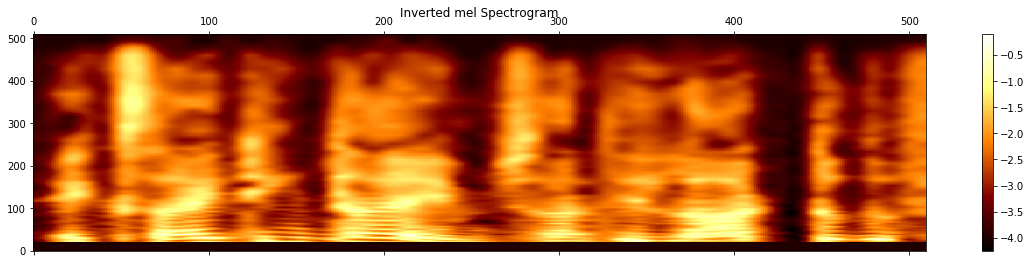

In [56]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.float32(mel_inverted_spectrogram), cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')

In [57]:
inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=16000)